In [4]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np

from deepxde.backend import tf
import matplotlib.pyplot as plt
D = 3.8e-11 #m^2/s
C0 = 0.0 #moles/m^3
C1 = 100 #moles/m^3
l = 0.05 #m
def pde(x, y):
   
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  
    return (dy_t- D*dy_xx)

def f(x):
    return np.sin(np.pi * x / l)
    
def func(x):
    n_terms = 2  # Number of terms in the series to approximate the solution
    result = C0 + (x[:, 0:1] / l) * (C1 - C0)
    for n in range(1, n_terms + 1):
        from scipy.integrate import quad
        integral, _ = quad(lambda x: f(x) * np.sin(n * np.pi * x/ l), 0, l)
        cn = (2 / l) * integral + (2 / (n * np.pi)) * ((-1)**n * (C1 - C0))  
        term = cn * np.exp(-n**2 * np.pi**2 * D * x[:, 1:2] / l**2) * np.sin(n * np.pi * x[:, 0:1] / l)
        result += term
    return result



geom = dde.geometry.Interval(0, l)
timedomain = dde.geometry.TimeDomain(0, 100)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=40, solution=func,num_boundary=20,num_initial=10, num_test=10000)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"


net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=500)
losshistory, train_state = model.train(iterations=100000)

Compiling model...
Building feed-forward neural network...
'build' took 0.042574 s



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.353936 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.96e-03, 3.98e+03, 2.86e+02]    [3.47e-04, 3.98e+03, 2.86e+02]    [1.00e+00]    
1000      [3.15e-02, 2.46e+03, 2.75e+02]    [6.69e+00, 2.46e+03, 2.75e+02]    [3.18e+00]    
2000      [1.13e+00, 1.81e+03, 1.50e+02]    [2.36e+01, 1.81e+03, 1.50e+02]    [3.68e+00]    
3000      [5.03e-01, 1.72e+03, 1.18e+02]    [6.02e+01, 1.72e+03, 1.18e+02]    [4.40e+00]    
4000      [2.21e-01, 1.72e+03, 1.18e+02]    [6.14e+01, 1.72e+03, 1.18e+02]    [4.44e+00]    
5000      [1.57e+00, 3.75e+01, 1.17e+02]    [3.57e+01, 3.75e+01, 1.17e+02]    [5.91e+00]    
6000      [8.93e-01, 5.07e-01, 1.17e+02]    [3.97e+01, 5.07e-01, 1.17e+02]    [6.28e+00]    
7000      [5.24e-01, 1.90e-01, 1.17e+02]    [3.82e+01, 1.90e-01, 1.17e+02]    [6.16e+00]    
8000      [8.26e-01, 2.12e-01, 1.17e+02]    [2.88e+01, 2.12e-01, 1.17e+02]    [5.29e+00]    
9000      [4.66e-01, 1.6

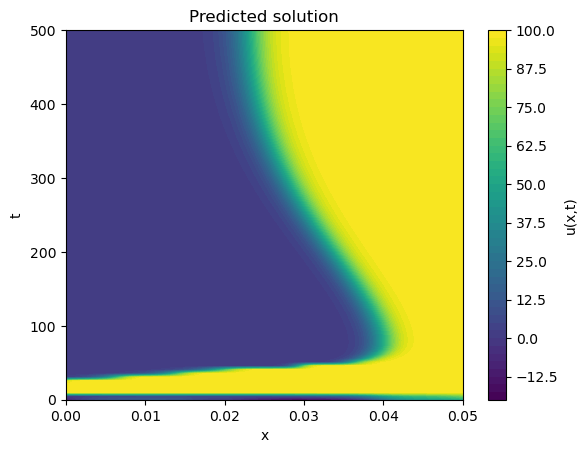

Saving loss history to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\train.dat ...
Saving test data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\test.dat ...


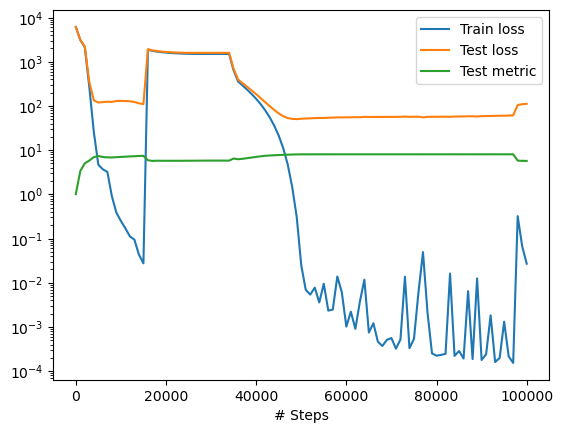

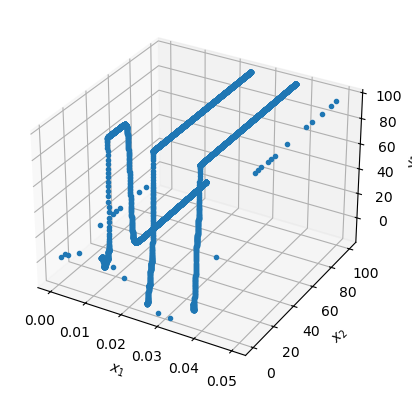

In [2]:
import matplotlib.pyplot as plt

# Create a grid of points to evaluate the solution
x = np.linspace(0, 0.05, 100)
t = np.linspace(0, 500, 100)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

# Plot the solution
plt.contourf(X, T, y_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution')
plt.show()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)